In [23]:
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA

# Cosinus normal des lignes d'une matrice
matrix.cos <- function(m) {
     (m %*% t(m)) / ( t(matrix(sqrt(rowSums(m^2)),nrow(m),nrow(m)))
                    * (sqrt(rowSums(m^2))) )
}

In [24]:
m.cos <- matrix.cos(m)                  # calcul de la distance en cosinus
diag(m.cos) <- 0                        # cosinus avec soi-même mis à 0
m.dist <- as.dist(m.cos)                # nécessaire pour l'agglomération (clustering)
res <- hclust(m.dist)                   # résultat de l'agglomération

In [25]:
set.seed(1)
dim.error <- c()
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
cv.dim <- c()
for (cut.dim in seq(1,900,10)){
cv.erreur <- c()
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
    

m.train.na <- m.train
m.train.na[m.train.na==0]<-0
m.cos <- matrix.cos(m.train)                  # calcul de la distance en cosinus
diag(m.cos) <- 0                        # cosinus avec soi-même mis à 0
m.dist <- as.dist(m.cos)                # nécessaire pour l'agglomération (clustering)
res <- hclust(m.dist)                   # résultat de l'agglomération
res2 <- cutree(res, k=cut.dim)               # on fixe à cut.dim le nombre de groupes
m.class <- data.frame(m.train,class=res2)     # création d'un data frame pour la fonction aggregate ci-dessous
## Aggrégation du vote moyen par classe (groupe) 
res3 <- aggregate(. ~ class, m.class, function(i) { i[i==0] <- NA; if(all(is.na(i))) NA else mean(i, na.rm=T) } )

## Création de la matrice de prédiction.  Les prédictions pour les utilisateurs sont fixées aux prédictions de la classe correspondante
mhat.class <- as.matrix(res3[,-1])      # on retire la classe des prédictions
## Création de la matrice de prédiction.  Les prédictions pour les utilisateurs sont fixées aux prédictions de la classe correspondante
m.hat <- t(sapply(m.class$class, function(class) mhat.class[class,]))
u.mean <- matrix(rowMeans(m.hat, na.rm=T), nrow(m), ncol(m))
item.mean <- matrix(colMeans(m.hat, na.rm=T), nrow(m), ncol(m), byrow=T)
m.expect <- ((u.mean + item.mean)/2)
m.hat[is.na(m.hat)] <- m.expect[is.na(m.hat)]

m.mean <- rep(rowMeans(m.hat,na.rm=T),1682)
m.hat[is.na(m.hat)] <- m.mean[is.na(m.hat)]
m.train[m.train==0] <- m.hat[m.train==0]
cv.erreur <-c(cv.erreur,mae(m.train[i.test.b],m[i.test.b]))

    }
cv.dim <- c(cv.dim,mean(cv.erreur))
}

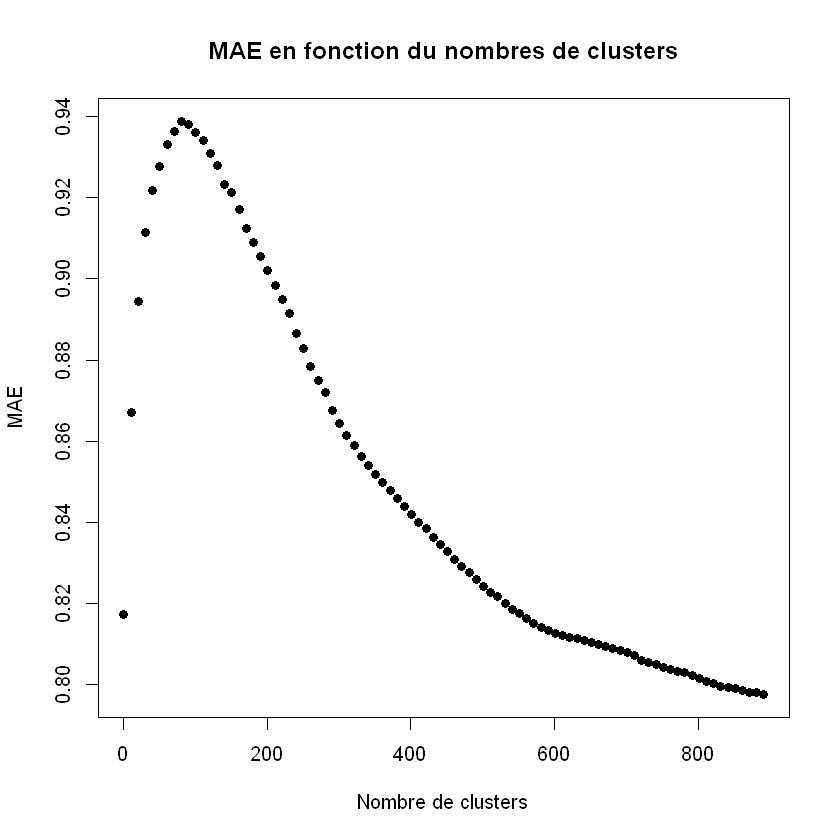

In [26]:
x <- seq(1,900,10)
plot(x,cv.dim,pch=19, xlab="Nombre de clusters", ylab="MAE",
    main="MAE en fonction du nombres de clusters"
)

In [27]:
m.cos <- matrix.cos(m)                  # calcul de la distance en cosinus
diag(m.cos) <- 0                        # cosinus avec soi-même mis à 0
m.dist <- as.dist(m.cos)                # nécessaire pour l'agglomération (clustering)
res <- hclust(m.dist)                   # résultat de l'agglomération
res2 <- cutree(res, k=5)               # on fixe à 10 le nombre de groupes
m.class <- data.frame(m,class=res2)     # création d'un data frame pour la fonction aggregate ci-dessous
## Aggrégation du vote moyen par classe (groupe) 
res3 <- aggregate(. ~ class, m.class, function(i) { i[i==0] <- NA; if(all(is.na(i))) NA else mean(i, na.rm=T) } )
m.hat <- res3[m.class$class,-1]
m.mean <- outer(rowMeans(m.na,na.rm=T),colMeans(m.na,na.rm=T),FUN="+")/2
m.hat[is.na(m.hat)] <- m.mean[is.na(m.hat)]

In [28]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.b], m.na[i.test.b])
    }
to.plot <- c()
cv.b <- c()

In [30]:
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
ptm <- proc.time()
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
    

m.train.na <- m.train
m.train.na[m.train.na==0]<-0
m.cos <- matrix.cos(m.train)                  # calcul de la distance en cosinus
diag(m.cos) <- 0                        # cosinus avec soi-même mis à 0
m.dist <- as.dist(m.cos)                # nécessaire pour l'agglomération (clustering)
res <- hclust(m.dist)                   # résultat de l'agglomération
res2 <- cutree(res, k=5)               # on fixe à 10 le nombre de groupes
m.class <- data.frame(m.train,class=res2)     # création d'un data frame pour la fonction aggregate ci-dessous
## Aggrégation du vote moyen par classe (groupe) 
res3 <- aggregate(. ~ class, m.class, function(i) { i[i==0] <- NA; if(all(is.na(i))) NA else mean(i, na.rm=T) } )

## Création de la matrice de prédiction.  Les prédictions pour les utilisateurs sont fixées aux prédictions de la classe correspondante
mhat.class <- as.matrix(res3[,-1])      # on retire la classe des prédictions
## Création de la matrice de prédiction.  Les prédictions pour les utilisateurs sont fixées aux prédictions de la classe correspondante
m.hat <- t(sapply(m.class$class, function(class) mhat.class[class,]))

m.mean <- outer(rowMeans(m.train.na,na.rm=T),colMeans(m.train.na,na.rm=T),FUN="+")/2
m.hat[is.na(m.hat)] <- m.mean[is.na(m.hat)]
m.train[m.train==0] <- m.hat[m.train==0]

m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
cv.b<-c(cv.b,mae(m.train[i.test.b], m.na[i.test.b]))
    }
(proc.time()-ptm)/5


   user  system elapsed 
 26.464   0.294  26.758 

In [31]:
to.plot<-apply(to.plot,2,unlist)

In [32]:
sdev <- apply(to.plot,2,sd) 
avg
avg <- colMeans(to.plot)
x <- 1:length(avg)

[1] 0.8170181 0.8236997 0.8326913 0.8392729 0.8474359 0.8356507 0.8350569
 [8] 0.8301696 0.8275964 0.8247092 0.8236765 0.8226818 0.8218491 0.8212873
[15] 0.8211086 0.8209244 0.8210735 0.8209372 0.8210330 0.8210173 0.8211189
[22] 0.8217835

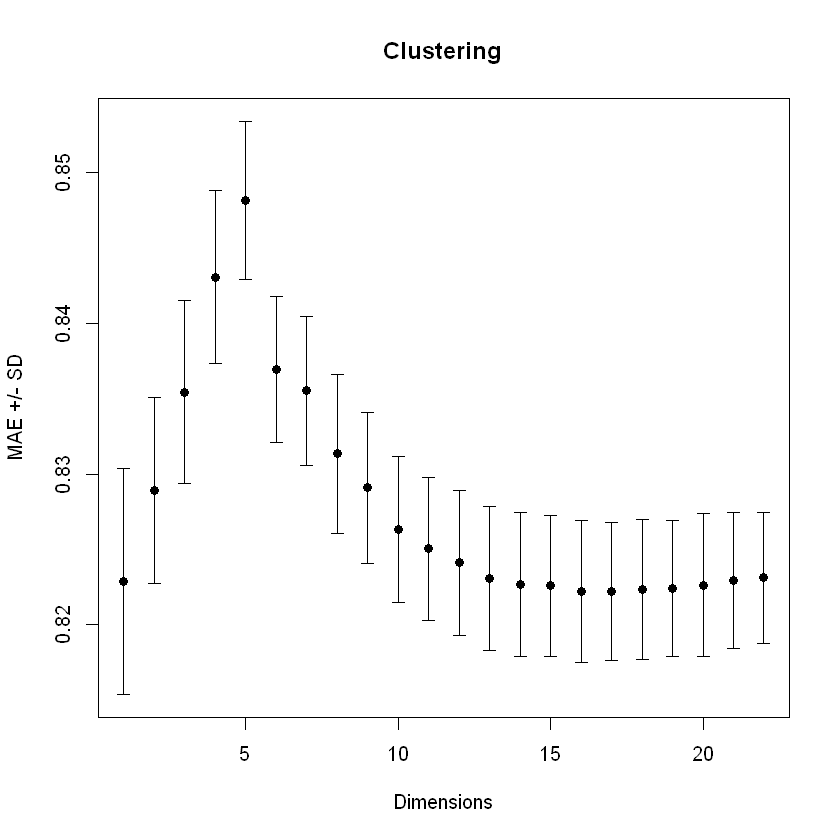

In [33]:
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Dimensions", ylab="MAE +/- SD",
    main="Clustering"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [42]:
mean(cv.b)

[1] 0.863604

In [41]:
write.table(avg,file="out/total/cluster.csv")